# Glucose-6-Phosphate Dehydrogenase, reversible (G6PDH2r)
To construct the glucose-6-phosphate dehydrogenase module, first we import __masspy__ and any additional packages that will be necessary.  

In [1]:
import os

import matplotlib.pyplot as plt

import numpy as np

from scipy import optimize

import sympy as sym

from cobra import DictList

from mass import MassMetabolite, Simulation, qcqa_model
from mass.enzyme_modules import EnzymeModule
from mass.io import json#, sbml
from mass.util import Keq2k, k2Keq, strip_time

Note that the total enzyme concentration of G6PDH2r is \\(1 \mu M = 0.001 mM\\).

## Module Construction
The first step of creating the G6PDH2r module is to define the EnzymeModule object.

__Note:__ All EnzymeModule specific attributes start will start the prefix "enzyme" or "enzyme_module".

In [2]:
G6PDH2r = EnzymeModule("G6PDH2r", name="Glucose 6-phosphate dehydrogenase",
                      subsystem="Pentose Phosphate Pathway")

## Metabolites
### Ligands
The next step is to define all of the ligands involved in the G6PDH2r catalytic mechanism using identifiers and the names found in the BiGG Database (http://bigg.ucsd.edu/). In order to ensure our module is physiologically accurate, it is important to provide the __formula__ keyword with a string representing the chemical formula for each metabolite, and the  __charge__ keyword with an integer representing the metabolite's ionic charge (Note that neutrally charged metabolites are provided with 0). To indicate that the cytosol is the cellular compartment in which the enzymatic reaction occurs, the string "c" is provided to the __compartment__ keyword.

First, the inhibitors, cofactors, and the substrate associated with this enzyme. There are 6 species which must be considered.

In [3]:
g6p_c = MassMetabolite(
    id="g6p_c",
    name="D-Glucose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c")
_6pgl_c = MassMetabolite(
    id="_6pgl_c",
    name="6-Phospho-D-gluco-1,5-lactone",
    formula="C6H9O9P",
    charge=-2,
    compartment="c")
nadp_c = MassMetabolite(
    id="nadp_c",
    name="Nicotinamide adenine dinucleotide phosphate",
    formula="C21H25N7O17P3",
    charge=-3,
    compartment="c")
nadph_c = MassMetabolite(
    id="nadph_c",
    name="Nicotinamide adenine dinucleotide phosphate - reduced",
    formula="C21H26N7O17P3",
    charge=-4,
    compartment="c")
atp_c = MassMetabolite(
    id="atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c")
h_c = MassMetabolite(
    id="h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c")

After generating the ligands, they are added to the EnzymeModule. The ligands of the EnzymeModule can be viewed using the __EnzymeModule.enzyme_module_ligands_categorized__ property. Note that all of the ligands are categorized as undefined. 

In [4]:
G6PDH2r.add_metabolites([g6p_c, _6pgl_c, nadp_c, nadph_c, atp_c, h_c])
for category, ligands in G6PDH2r.enzyme_module_ligands_categorized.items():
    print("{0}: {1}".format(category, str([m.id for m in ligands])))

Undefined: ['_6pgl_c', 'atp_c', 'g6p_c', 'h_c', 'nadp_c', 'nadph_c']


When metabolites are first added to an EnzymeModule, they are placed in the "Undefined" category. The __EnzymeModule.enzyme_module_ligands_categorized__ property can also be used to reassign metabolites to user-defined categories by providing a dictionary where keys are the categories and values are the metabolites. Note that a metabolite can be given placed in more than one category.

In [5]:
G6PDH2r.enzyme_module_ligands_categorized =  {
    "Substrates": g6p_c,
    "Cofactors": nadp_c,
    "Inhibitors": atp_c,
    "Products": [_6pgl_c, nadph_c, h_c]}
for category, ligands in G6PDH2r.enzyme_module_ligands_categorized.items():
    print("{0}: {1}".format(category, str([m.id for m in ligands])))

Substrates: ['g6p_c']
Cofactors: ['nadp_c']
Inhibitors: ['atp_c']
Products: ['_6pgl_c', 'h_c', 'nadph_c']


### Enzyme Forms

This G6PDH2r module will be considered a monomer with a ordered sequential mechanism. There is also a categorized enzyme form dictionary, accessible via __EnzymeModule.enzyme_module_forms_categorized__, that behaves similarly to the __EnzymeModule.enzyme_module_ligands_categorized__ attribute, as shown below. Alternatively, one can access a __cobra.DictList__ of all EnzymeForms through the __EnzymeModule.enzyme_module_forms__ attribute.

In [6]:
G6PDH2r.make_enzyme_module_form(
    id="g6pdh2r_c",
    name="Automatic",
    categories="Free",
    compartment="c")
G6PDH2r.make_enzyme_module_form(
    id="g6pdh2r_G_c",
    name="Automatic",
    categories="Free",
    bound_catalytic={g6p_c: 1},
    compartment="c")
G6PDH2r.make_enzyme_module_form(
    id="g6pdh2r_GN_c",
    name="Automatic",
    categories="Free",
    bound_catalytic={g6p_c: 1, nadp_c: 1},
    compartment="c")
G6PDH2r.make_enzyme_module_form(
    id="g6pdh2r_GN_P_c",
    name="Automatic",
    categories="Free",
    bound_catalytic={_6pgl_c: 1, nadph_c: 1},
    compartment="c")
G6PDH2r.make_enzyme_module_form(
    id="g6pdh2r_G_P_c",
    name="Automatic",
    categories="Free",
    bound_catalytic={_6pgl_c: 1},
    compartment="c")
G6PDH2r.make_enzyme_module_form(
    id="g6pdh2r_N_PI_c",
    name="Automatic",
    categories="Inhibited",
    bound_catalytic={nadph_c: 1},
    compartment="c")
G6PDH2r.make_enzyme_module_form(
    id="g6pdh2r_A_CI_c",
    name="Automatic",
    categories="Inhibited",
    bound_catalytic={atp_c: 1},
    compartment="c")

# Display newly made EnzymeForms in their categories
for category, enzyme_module_forms in G6PDH2r.enzyme_module_forms_categorized.items():
    print("{0}: {1}".format(category, str([r.id for r in enzyme_module_forms])))

Free: ['g6pdh2r_GN_P_c', 'g6pdh2r_GN_c', 'g6pdh2r_G_P_c', 'g6pdh2r_G_c', 'g6pdh2r_c']
Inhibited: ['g6pdh2r_A_CI_c', 'g6pdh2r_N_PI_c']


## Reactions
### Enzyme Reactions
Once all of the MassMetabolite and EnzymeForm objects have been created for each of the species in G6PDH2r, the next step is to define all of the reactions that occur in its mechanism. The __EnzymeModule.make_enzyme_module_reaction__ method can be used to create an enzyme binding reaction, a reaction represnting a transition between states, etc. It requires the same parameters needed to initialize a MassReaction, and it allows for one to define a category for the reaction, similar to how ligands can be categorized and accessible through the __EnzymeModule.enzyme_module_reactions__ property. Additionally, metabolites and EnzymeForms can also be directly added to the reaction by providing the __add_metabolites__ kwarg a dictionary, where keys can be EnzymeForm and MassMetabolites objects or their ids if they already exist in the EnzymeModule, and values are the stoichiometric coefficients (reactants have negative coefficients, products have positive ones). Note that after the creation of each MassReaction object, the reaction is added to the EnzymeModule.

In this module of G6PDH2r, there are 7 reactions occuring.

In [7]:
G6PDH2r.make_enzyme_module_reaction(
    id="G6PDH2r_1",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="product inhibition",
    metabolites_to_add={
        "g6pdh2r_c": -1,
        "nadph_c": -1,
        "g6pdh2r_N_PI_c": 1})

G6PDH2r.make_enzyme_module_reaction(
    id="G6PDH2r_2",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="product inhibition",
    metabolites_to_add={
        "g6pdh2r_c": -1,
        "atp_c": -1,
        "g6pdh2r_A_CI_c": 1})

G6PDH2r.make_enzyme_module_reaction(
    id="G6PDH2r_3",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="g6p_c binding",
    metabolites_to_add={
        "g6pdh2r_c": -1,
        "g6p_c": -1,
        "g6pdh2r_G_c": 1})

G6PDH2r.make_enzyme_module_reaction(
    id="G6PDH2r_4",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="_6pgl_c release",
    metabolites_to_add={
        "g6pdh2r_G_P_c": -1,
        "_6pgl_c": 1,
        "g6pdh2r_c": 1})

G6PDH2r.make_enzyme_module_reaction(
    id="G6PDH2r_5",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="nadp_c binding",
    metabolites_to_add={
        "g6pdh2r_G_c": -1,
        "nadp_c": -1,
        "g6pdh2r_GN_c": 1})

G6PDH2r.make_enzyme_module_reaction(
    id="G6PDH2r_6",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="nadph_c release",
    metabolites_to_add={
        "g6pdh2r_GN_P_c": -1,
        "nadph_c": 1,
        "g6pdh2r_G_P_c": 1})

G6PDH2r.make_enzyme_module_reaction(
    id="G6PDH2r_7",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="catalyzation",
    metabolites_to_add={
        "g6pdh2r_GN_c": -1,
        "g6pdh2r_GN_P_c": 1,
        "h_c": 1})

# Display newly made reactions in their categories
for category, enzyme_module_reactions in G6PDH2r.enzyme_module_reactions_categorized.items():
    print("{0}: {1}".format(category, str([r.id for r in enzyme_module_reactions])))

product inhibition: ['G6PDH2r_1', 'G6PDH2r_2']
g6p_c binding: ['G6PDH2r_3']
_6pgl_c release: ['G6PDH2r_4']
nadp_c binding: ['G6PDH2r_5']
nadph_c release: ['G6PDH2r_6']
catalyzation: ['G6PDH2r_7']


## The Steady State
### Solve steady state concentrations symbolically
To determine the steady state of the enzyme, first we will identify the enzyme forms and store them in a list. Then, we define a dictionary of the ordinary differential equations as sympy expressions.

In [8]:
ode_dict = {
    sym.Symbol(enzyme_module_form.id): sym.Eq(strip_time(enzyme_module_form.ode))
    for enzyme_module_form in G6PDH2r.enzyme_module_forms}

We also use the catalyzation reactions in order to create our equation for \\(v_{\mathrm{G6PDH2r}}\\).

In [9]:
G6PDH2r.make_enzyme_net_flux_equation(G6PDH2r.enzyme_module_reactions_categorized["catalyzation"], 
                                      use_rates=True, update_enzyme=True)
sym.pprint(G6PDH2r.enzyme_net_flux_equation)

            kf_G6PDH2r_7⋅(Keq_G6PDH2r_7⋅g6pdh2r_GN_c(t) - g6pdh2r_GN_P_c(t))
v_G6PDH2r = ────────────────────────────────────────────────────────────────
                                     Keq_G6PDH2r_7                          


We then identify equations for the unknown concentrations we wish to solve for in each reaction. We will treat the completely free form of the enzyme with no bound species as our dependent variable.

In [10]:
# Get enzyme forms
enzyme_module_forms = G6PDH2r.enzyme_module_forms.copy()

enzyme_solutions = {}
for enzyme_module_form in enzyme_module_forms:
    # Skip dependent variable
    if "g6pdh2r_c" == str(enzyme_module_form):
        continue
    else:
        enzyme_module_form = sym.Symbol(enzyme_module_form.id)
    # Solve for the enzyme form and update the solution dictionary
    sol = list(sym.solveset(ode_dict[enzyme_module_form].subs(enzyme_solutions), enzyme_module_form))
    enzyme_solutions[enzyme_module_form] = sol.pop()
    enzyme_solutions.update({enzyme_module_form: sol.subs(enzyme_solutions) 
                             for enzyme_module_form, sol in enzyme_solutions.items()})

The reaction rate equation can be utilized as the last necessary equation in order to solve for the our final unknown concentration variable in terms of the rate and equilibrium constants. Once the unknown variable has been solved for, we substitute the solution back into our other equations. Because __sym.solveset__ expects the input equations to be equal to 0, we can use the __EnzymeModule.enzyme_net_flux_error__ method to get the appropriate expression.

In [11]:
# Solve for enzyme form
sym.pprint(strip_time(G6PDH2r.enzyme_net_flux_error()))
sol = sym.solveset(strip_time(G6PDH2r.enzyme_net_flux_error()).subs(enzyme_solutions), 
                   "g6pdh2r_c")
# Add to solution dictionary
enzyme_solutions[sym.Symbol("g6pdh2r_c")] = list(sol).copy().pop()
# Update solutions with free variable solutions
enzyme_solutions = {enzyme_module_form: sym.simplify(solution.subs(enzyme_solutions))
                    for enzyme_module_form, solution in enzyme_solutions.items()}

            kf_G6PDH2r_7⋅(Keq_G6PDH2r_7⋅g6pdh2r_GN_c - g6pdh2r_GN_P_c)
v_G6PDH2r - ──────────────────────────────────────────────────────────
                                  Keq_G6PDH2r_7                       


#### Numerical Values
At this point, numerical values are defined for the dissociation constants and the concentrations of the substrates, cofactors, activators, and inhibitors. Providing these numerical values will speed up the subsequent calculations. 

To do this, experimental data is used to define the dissociations constants for the different binding steps under the QEA assumption. The concentrations of the non-enzyme species are taken from the glycolysis model. 

Experimental data gives the following for the dissociation constants: 

$$K_{i, \text{NADPH}} = 0.024,\ K_{i, \text{ATP}} = 0.044,\ K_{\text{G6P}} = 0.027,\ K_{\text{GL6P}} = 0.050,\ K_{\text{NADP}} = 0.019,\ K_{\text{NADPH}} = 0.0105$$ 

which gives us a value of $K_{\text{G6PDH2r}} = \frac{1000}{\frac{K_{\text{GL6P}}K_{\text{NADPH}}}{K_{\text{G6P}}K_{\text{NADP}}}} = \frac{1000}{\frac{0.050\ *\ 0.0105}{0.027\ *\ 0.019}}$ for the catalyzation step.

In [12]:
numerical_values = {}

# Get ligand IDs
ligand_ids = sorted([str(ligand) for ligand in G6PDH2r.enzyme_module_ligands])
parameter_ids = [r.Keq_str for r in G6PDH2r.enzyme_module_reactions]
# Load the glycolysis model and hemoglobin model to extract steady state values
glycolysis = json.load_json_model(os.path.abspath("../../test-models/json-models/glycolysis.json"))
ppp = json.load_json_model(os.path.abspath("../../test-models/json-models/pentose_phosphate_pathway.json"))
fullppp = glycolysis.merge(ppp)

# Get the steady state flux value and add to numerical values
G6PDH2r.enzyme_net_flux = fullppp.reactions.get_by_id(G6PDH2r.id).steady_state_flux
numerical_values.update({G6PDH2r.enzyme_flux_symbol: G6PDH2r.enzyme_net_flux})

# Get the steady state concentration values and add to numerical values
initial_conditions = {
    str(ligand): fullppp.initial_conditions[fullppp.metabolites.get_by_id(ligand)]
    for ligand in ligand_ids}
numerical_values.update(initial_conditions)

# Define parameter values and add to numerical values
G6PDH2r.enzyme_module_reactions.G6PDH2r_1.Keq = 1/0.024
G6PDH2r.enzyme_module_reactions.G6PDH2r_2.Keq = 1/0.044
G6PDH2r.enzyme_module_reactions.G6PDH2r_3.Keq = 1/0.027
G6PDH2r.enzyme_module_reactions.G6PDH2r_4.Keq = 0.050
G6PDH2r.enzyme_module_reactions.G6PDH2r_5.Keq = 1/0.019
G6PDH2r.enzyme_module_reactions.G6PDH2r_6.Keq = 0.0105
G6PDH2r.enzyme_module_reactions.G6PDH2r_7.Keq = 1000/((0.05*0.0105)/(0.019*0.027))

numerical_values.update({reaction.Keq_str: reaction.Keq 
                         for reaction in G6PDH2r.enzyme_module_reactions})

# Substitute values into equations
enzyme_solutions = {enzyme_module_form: sym.simplify(solution.subs(numerical_values))
                    for enzyme_module_form, solution in enzyme_solutions.items()}

# Display numerical values
for k, v in numerical_values.items():
    print("{0} = {1}".format(k, v))

Ignoring reaction 'EX_h_e' since it already exists.


Ignoring reaction 'EX_h2o_e' since it already exists.


v_G6PDH2r = 0.21
_6pgl_c = 0.00175424
atp_c = 1.6
g6p_c = 0.0486
h_c = 8.99757e-05
nadp_c = 0.0002
nadph_c = 0.0658
Keq_G6PDH2r_1 = 41.666666666666664
Keq_G6PDH2r_2 = 22.72727272727273
Keq_G6PDH2r_3 = 37.03703703703704
Keq_G6PDH2r_4 = 0.05
Keq_G6PDH2r_5 = 52.631578947368425
Keq_G6PDH2r_6 = 0.0105
Keq_G6PDH2r_7 = 977.1428571428569


The last part of this step is to simplify the solutions for the enzyme forms and, as a QCQA, ensure that only rate constants are the only symbolic arguments in the solutions. 

In [13]:
args = tuple(sorted(set([
    str(arg) for sol in enzyme_solutions.values() 
    for arg in list(sol.atoms(sym.Symbol))])))
print(args)

('kf_G6PDH2r_3', 'kf_G6PDH2r_4', 'kf_G6PDH2r_5', 'kf_G6PDH2r_6', 'kf_G6PDH2r_7')


### Determine rate constants
#### Total Enzyme Concentration and $r_{T}$ 
After solving for the enzyme forms, the next step is to define equations for the total enzyme concentration and for the fraction of the enzyme in the inhibited state to be used as constraints for determining the rate parameters. To view the equation for the total enzyme concentration, we can use the __EnzymeModule.total_enzyme_equation__ property.

In [14]:
sym.pprint(G6PDH2r.enzyme_concentration_total_equation)

G6PDH2r_Total = g6pdh2r_A_CI_c(t) + g6pdh2r_GN_P_c(t) + g6pdh2r_GN_c(t) + g6pd
h2r_G_P_c(t) + g6pdh2r_G_c(t) + g6pdh2r_N_PI_c(t) + g6pdh2r_c(t)


The total concentration of G6PDH2r is 0.001 mM. The __EnzymeModule.total_enzyme_concentration__ atrribute can be used to set and store this concentration.

In [15]:
G6PDH2r.enzyme_concentration_total = 1e-3
print(G6PDH2r.enzyme_concentration_total)

0.001


To determine the rate constants, we can set up an optimization problem where we minimize the error between the measured and calculated total enzyme concentrations. We start by creating the objective function based on the absolute error between the measured and calculated total enzyme concentrations. We can use the __EnzymeModule.enzyme_concentration_total_error__ method to get the symbolic expression for the constraint. 

In [16]:
enzyme_total_constraint = abs(strip_time(G6PDH2r.enzyme_concentration_total_error()))
sym.pprint(enzyme_total_constraint)

│-G6PDH2r_Total + g6pdh2r_A_CI_c + g6pdh2r_GN_P_c + g6pdh2r_GN_c + g6pdh2r_G_P
_c + g6pdh2r_G_c + g6pdh2r_N_PI_c + g6pdh2r_c│


We introduce our solutions for the enzyme forms to get an equation for the error in the enzyme total concentration in terms of the rate constants.

In [17]:
enzyme_total_constraint = sym.simplify(enzyme_total_constraint.subs(
    enzyme_solutions).subs({G6PDH2r.enzyme_total_symbol: G6PDH2r.enzyme_concentration_total}))
sym.pprint(enzyme_total_constraint)
obj_func = lambda x: sym.lambdify(args, enzyme_total_constraint)(*x)

│         473.104442284003   0.694171212863746   24889.1811728423   4.56013960
│-0.001 + ──────────────── + ───────────────── + ──────────────── + ──────────
│           kf_G6PDH2r_7        kf_G6PDH2r_6       kf_G6PDH2r_5       kf_G6PDH

061281   176.586527206239│
────── + ────────────────│
2r_4       kf_G6PDH2r_3  │


Lastly, we place lower and upper bounds on the rate constants to ensure that the values are non-negative and are within physiological limits, and then we solve the optmization problem. Once the optimization has finished, we check whether it was successful, and if so, what the optimality and errors are associated with this particular solution instance.

In [18]:
r_T_expr = G6PDH2r.make_enzyme_fraction("forms", top="Inhibited", bottom="Equation")
r_T_expr = sym.simplify(strip_time(r_T_expr).subs(enzyme_solutions))

print("Ordered Args: {0}\n".format(str(args)))

bounds = ((1e3, 1e9), (1e3, 1e9), (1e3, 1e9), (1e3, 1e9), (1e3, 1e9))

sol = optimize.minimize(
    obj_func, [1e4, 1e4, 1e4, 1e4, 1e4], method="trust-constr", bounds=bounds, 
    options={"gtol": 1e-12, "xtol": 1e-12, "maxiter": 1e4, "disp": True})

parameter_values = dict(zip(args, [round(x) for x in sol.x]))

print("\nOptimization Success: {0}".format(sol.success))
if sol.success:
    print("Otimization Optimality: {0:.4e}".format(sol.optimality))
    print("Optimization Error: {0:.4e}".format(enzyme_total_constraint.subs(parameter_values)))
    print("Parameter Solutions: {:}".format(str({arg: parameter_values[arg] for arg in args})))
    print("Enzyme T-fraction: {:.4f}".format(r_T_expr.subs(parameter_values)))

Ordered Args: ('kf_G6PDH2r_3', 'kf_G6PDH2r_4', 'kf_G6PDH2r_5', 'kf_G6PDH2r_6', 'kf_G6PDH2r_7')



`xtol` termination condition is satisfied.
Number of iterations: 121, function evaluations: 600, CG iterations: 330, optimality: 3.32e-11, constraint violation: 0.00e+00, execution time:  2.3 s.

Optimization Success: True
Otimization Optimality: 3.3218e-11
Optimization Error: 5.1513e-12
Parameter Solutions: {'kf_G6PDH2r_3': 2603675.0, 'kf_G6PDH2r_4': 471114.0, 'kf_G6PDH2r_5': 31681489.0, 'kf_G6PDH2r_6': 162428.0, 'kf_G6PDH2r_7': 3567413.0}
Enzyme T-fraction: 0.9260


/Users/zhaiman/miniconda3/envs/masspy-dev/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187 UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.


With a successful optimization, the module is updated with the parameter values.  The inhibition and activation reactions are set to have a high forward rate constant and the allosteric transition even higher, limiting the amount of unbound enzyme and ensuring the R-T transition dynamics are determined only by its allosteric constant. 

__Note:__ This assumption for the rate constants can be made because none of the enzyme concentrations are dependendent on the activation, inhibition, and allosteric rate constants.

In [19]:
# Add the inhibition rate constants
parameter_values.update({"kf_" + rxn: 1e6 for rxn in ["G6PDH2r_1", "G6PDH2r_2"]})

### Solve steady state concentrations numerically

Once the rate constants have been defined, the steady state concentrations of the enzyme can be determined.

In [20]:
# Substitute values into equations
initial_conditions.update({
    str(enzyme_module_form): round(float(sym.simplify(solution.subs(parameter_values))), 12)
    for enzyme_module_form, solution in enzyme_solutions.items()})

for header, dictlist in zip(["Ligand", "\nEnzyme"], [G6PDH2r.enzyme_module_ligands, G6PDH2r.enzyme_module_forms]):
    header += " Concentrations"
    print("\n".join([header, "-" * len(header)]))
    for species in dictlist:
        ic = initial_conditions[species.id]
        print("{0} = {1}".format(species.id, ic))

Ligand Concentrations
---------------------
g6p_c = 0.0486
_6pgl_c = 0.00175424
nadp_c = 0.0002
nadph_c = 0.0658
atp_c = 1.6
h_c = 8.99757e-05

Enzyme Concentrations
----------------------
g6pdh2r_c = 2.3680761e-05
g6pdh2r_G_c = 3.9638138e-05
g6pdh2r_GN_c = 6.8376e-08
g6pdh2r_GN_P_c = 9.292824e-06
g6pdh2r_G_P_c = 1.276587e-06
g6pdh2r_N_PI_c = 6.4924752e-05
g6pdh2r_A_CI_c = 0.000861118567


#### Set Initial Conditions and Parameters
Once the steady state concentrations have been determined, the initial conditions and parameters are added to the module.

In [21]:
# Set initial conditions
for met, concentration in initial_conditions.items():
    G6PDH2r.metabolites.get_by_id(str(met)).ic = concentration
G6PDH2r.set_initial_conditions()

# Assign parameter values for reactions that do not use custom parameters
for reaction in G6PDH2r.reactions:
    reaction.kf = parameter_values[reaction.kf_str]

#### Optional: Ordering of internal species and reactions
Sometimes, it is also desirable to reorder the metabolite and reaction objects inside the module to follow the physiology. To reorder the internal species, one can use the method __cobra.DictList.get_by_any__ method with the list of metabolite identifiers in the desirable order. To ensure all metabolites are still present and not forgotten in the module, a QC/QA check is also performed. 

In [22]:
new_metabolite_order = ["g6p_c","_6pgl_c", "atp_c", "nadp_c", "nadph_c", "h_c", 
                        "g6pdh2r_c", "g6pdh2r_G_c", "g6pdh2r_GN_c",
                        "g6pdh2r_GN_P_c", "g6pdh2r_G_P_c", 
                        "g6pdh2r_A_CI_c", "g6pdh2r_N_PI_c"]

if len(G6PDH2r.metabolites) == len(new_metabolite_order):
    G6PDH2r.metabolites = DictList(G6PDH2r.metabolites.get_by_any(new_metabolite_order))
    
new_reaction_order = ["G6PDH2r_1", "G6PDH2r_2", "G6PDH2r_3", "G6PDH2r_4", 
                      "G6PDH2r_5", "G6PDH2r_6", "G6PDH2r_7"]

if len(G6PDH2r.reactions) == len(new_reaction_order):
    G6PDH2r.reactions = DictList(G6PDH2r.reactions.get_by_any(new_reaction_order))
    
G6PDH2r.update_S(matrix_type="DataFrame", dtype=np.int64)

,G6PDH2r_1,G6PDH2r_2,G6PDH2r_3,G6PDH2r_4,G6PDH2r_5,G6PDH2r_6,G6PDH2r_7
g6p_c,0,0,-1,0,0,0,0
_6pgl_c,0,0,0,1,0,0,0
atp_c,0,-1,0,0,0,0,0
nadp_c,0,0,0,0,-1,0,0
nadph_c,-1,0,0,0,0,1,0
h_c,0,0,0,0,0,0,1
g6pdh2r_c,-1,-1,-1,1,0,0,0
g6pdh2r_G_c,0,0,1,0,-1,0,0
g6pdh2r_GN_c,0,0,0,0,1,0,-1
g6pdh2r_GN_P_c,0,0,0,0,0,-1,1


## Module Validation 
### QC/QA Model
Before saving the module, it is important to ensure that the module is elementally balanced, and that the module can be integrated into a larger network for simulation. Therefore, the __qcqa_model__ method is used to provide a report on the module quality and indicate whether simulation is possible and if not, what parameters and/or initial conditions are missing.

In [23]:
qcqa_model(G6PDH2r, parameters=True, concentrations=True, 
           fluxes=False, superfluous=True, elemental=True)

╒═══════════════════════════════╕
│ MODEL ID: G6PDH2r             │
│ SIMULATABLE: True;            │
│ NUMERICAL CONSISTENCY: True   │
╞═══════════════════════════════╡
╘═══════════════════════════════╛


### Constraint Satisfaction and Error Values
Another QC/QA check we perform is to substitute the steady state numerical values back into the constraints used in determining the rate constants in order to ensure that the constraints remain satisified, and that errors are small. 

In [24]:
print("Concentration Absolute Error: {0:.4e}".format(
    abs(G6PDH2r.enzyme_concentration_total_error(use_values=True))))
print("Flux Absolute Error: {0:.4e}".format(
    abs(G6PDH2r.enzyme_net_flux_error(use_values=True))))

Concentration Absolute Error: 5.0000e-12
Flux Absolute Error: 1.3798e-06


### Add Enzyme to MassModel
In order to determine whether the module can be successfully integrated into a model, another model can be loaded, merged with the module, and simulated. To validate this module, it will be merged with a __glycolysis__ model and a __hemoglobin__ module. 

To integrate the EnzymeModule into the MassModel, we first remove the reaction that the EnzymeModule will be replacing. Afterwards, we can use the __MassModel.merge__ method to add the EnzymeModule. When merging an EnzymeModule and a MassModel, the EnzymeModule should always be merged into the MassModel.

In [25]:
# Load and merge glycolysis and hemoglobin models
glycolysis = json.load_json_model(os.path.abspath("../../test-models/json-models/glycolysis.json"))
ppp = json.load_json_model(os.path.abspath("../../test-models/json-models/pentose_phosphate_pathway.json"))
fullppp = glycolysis.merge(ppp)
fullppp.modules.add(glycolysis.id)
# Remove the G6PDH2r MassReaction, then merge the EnzymeModule into the MassModel
fullppp.remove_reactions(fullppp.reactions.get_by_id("G6PDH2r"))
fullppp_G6PDH2r = fullppp.merge(G6PDH2r)
fullppp_G6PDH2r

Ignoring reaction 'EX_h_e' since it already exists.


Ignoring reaction 'EX_h2o_e' since it already exists.


Name,Glycolysis_Pentose_Phosphate_Pathway_G6PDH2r
Memory address,0x01231297b8
Stoichiometric Matrix,39x43
Matrix Rank,35
Matrix Type,"dense, float64"
Number of Metabolites,39
Number of Reactions,43
Number of Initial Conditions,39
Number of Forward Rate Constants,43
Number of Equilibrium Constants,43
Number of Irreversible Reactions,8


Using __MassModel.merge(EnzymeModule)__ enables the EnzymeModule and MassModel to be merged like regular MassModel objects. However, all attributes specific to the EnzymeModule (e.g categorized attributes) are condensed into a speciailzed container called an __EnzymeModuleDict__. The EnzymeModuleDict is a special in that its contents can be accessed as if they were attributes. These attributes can be viewed using __EnzymeModuleDict.keys()__.
All __EnzymeModuleDicts__ can be accessed via __MassModel.enzyme_modules__.


In [26]:
print(str(fullppp_G6PDH2r.enzyme_modules) + "\n")
print("Attribute Accessors:\n-------------------\n" + "\n".join(list(
    fullppp_G6PDH2r.enzyme_modules.G6PDH2r.keys())) + "\n")
fullppp_G6PDH2r.enzyme_modules.G6PDH2r

[<EnzymeModule G6PDH2r at 0x122f4e158>]

Attribute Accessors:
-------------------
id
name
subsystem
enzyme_module_ligands
enzyme_module_forms
enzyme_module_reactions
enzyme_module_ligands_categorized
enzyme_module_forms_categorized
enzyme_module_reactions_categorized
enzyme_concentration_total
enzyme_net_flux
enzyme_net_flux_equation
description
S
model



Name,G6PDH2r
Memory address,0x0122f4e158
Stoichiometric Matrix,13x7
Matrix Rank,7
Subsystem,Pentose Phosphate Pathway
Number of Ligands,6
Number of EnzymeForms,7
Number of EnzymeModuleReactions,7
Enzyme Concentration Total,0.001
Enzyme Net Flux,0.21


### Validate Steady State
To find the steady state of the model, the __Simulation.find_steady_state_model__ method can used. 
To validate the steady state of the model, concentration and flux solutions can be plotted using the __plot_simulation__ function.

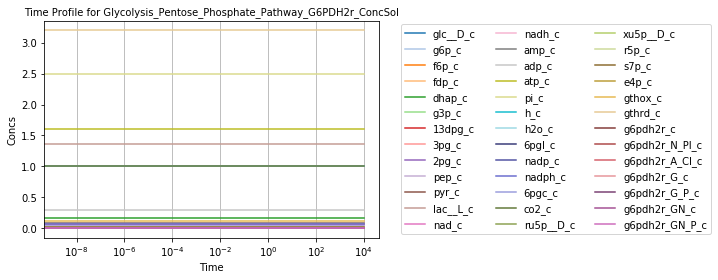

In [27]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(fullppp_G6PDH2r)
options={'method': 'LSODA', 'atol': 1e-15}
sim.find_steady_state_model(model=fullppp_G6PDH2r, strategy="simulate",
                            update_initial_conditions=True, 
                            update_reactions=True, **options)

t0, tf = (0, 1e4)
conc_sol, flux_sol = sim.simulate_model(fullppp_G6PDH2r, time=(t0, tf), **options)
conc_sol.preview_time_profile

### Optional Information: Storing references
#### Compartment
Because the character "c" represents the cytosol compartment, it is recommended to define and set the compartment in the __EnzymeModule.compartments__ attribute.

In [28]:
G6PDH2r.compartments = {"c": "Cytosol"}
print(G6PDH2r.compartments)

{'c': 'Cytosol'}


#### Units
All of the units for the numerical values used in this module are "Millimoles" for amount, "Liters" for volume, and "Hours" for time. In order to ensure that future users understand the numerical values for module, it is important to define the __EnzymeModule.units__ attribute. Like the __compartment__ attribute, the __units__ attribute is a dictionary and can easily be updated using the same methods.

Note that this attribute will NOT track units, but instead acts as a reference for the user and others so that they can perform necessary unit conversions.

In [29]:
G6PDH2r.units = {'N': 'Millimoles', 'Vol': 'Liters', 'Time': 'Hours'}
G6PDH2r.units

{'N': 'Millimoles', 'Vol': 'Liters', 'Time': 'Hours'}

## Export
After validation, the module is ready to be saved. The module can either be exported as a ".json" file or if the module conforms to SBML standards, as a ".xml" file using the classes in __mass.io__. To export the module, only the path to the directory and the name of the module need to be specified. Both are shown. 

### Export using JSON

In [30]:
json.save_json_model(G6PDH2r, os.path.abspath("../../test-models/json-models/G6PDH2r.json"))

### Export using SBML

In [31]:
# sbml.write_sbml_model(G6PDH2r, "os.path.abspath(../../test-models/sbml-models/G6PDH2r.xml"))